# Applying Amortized Inference to Inducible Simple Repression

In [1]:
import numpy as np 
import pandas as pd 
import bayesflow as bf
import tensorflow as tf
from functools import partial
from utils import * 
RNG = np.random.default_rng()#309348)
cor, pal = matplotlib_style()

/Users/gchure/Dropbox/git/postdoc_projects/scrappy/.venv/lib/python3.10/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


To learn how amortized inference operates (and how to use the BayesFlow) package,
I'm going to apply it to a simple model of gene expression developed 
during my PhD. This model examines how the expression of a gene regulated by 
a inducible repressor protein. Skipping over the derivation, we can state
that the fold-change in gene expression (relative to an unregulated promoter)
follows
$$
\text{fold-change} = \left(1 + p_A(c)\frac{R}{N_{NS}}e^{-\beta \Delta \varepsilon_{RA}}\right)^{-1} \tag{1}
$$
where $R$ is the number of repressors per cell, $N_{NS}$ is the number of nonspecific binding sites, $\Delta \varepsilon_{RA}$ is the binding energy of the repressor to the promoter, $\beta$ is $1/k_BT$ and $p_A(c)$ the probability 
that the repressor is in its active state as a function of the inducer concentration
$c$. We can turn the crank through statistical mechanics to enumerate this probability 
as 
$$
p_{A}(c) = \frac{\left(1 + \frac{c}{K_A}\right)^2}{\left(1 + \frac{c}{K_A}\right)^2 + e^{-\beta \Delta \varepsilon_{AI}\left(1 + \frac{c}{K_I}\right)^2}} \tag{2},
$$
where $K_A$ and $K_I$ are dissociation constants of the inducer to the active and
inactive states of the repressor, respectively, and $\Delta \varepsilon_{AI}$ is 
the energy difference between the active and inactive states.  

In [Razo-Mejia et al. 2018](https://www.cell.com/fulltext/S2405-4712(18)30057-7), we sought to 
test this theory by measuring the fold-change in gene expression of a LacI-regulated 
promoter in *E. coli* as a function of the inducer concentration. Using previous 
measurements, we had knowledge of all parameters in Eqs 1 and 2 except for $K_A$
and $K_I$. We used a Bayesian approach to infer these parameters, and found that
the model was able to predict the fold-change in gene expression using various operator 
sequences and repressor copy numbers, demonstrating the generality of the 
model for the simple repression motif. 

In that work, we used a Markov Chain Monte Carlo (MCMC) approach to infer the
parameters and approximate the true posterior density. Here, we will try 
to do the same thing using an amortized approach, even though the model 
itself is not that complicated.

## Defining the Inferential Model
We are interested in estimating the parameters $K_A$ and $K_I$ from a collection 
of fold-change measurements. Mathematically, we wish to compute or approximate 
the posterior density
$$
g(K_A, K_I\,\vert\, fc) = \frac{f(fc\,\vert\, K_A, K_I)g(K_A, K_I)}{f(fc)}, \tag{3}
$$
where $g$ and $f$ correspond to probability densities over parameters and data, 
respectively, $fc$ corresponds to a fold-change measurement. We assume that the 
likelihood $f(fc\,\vert\, K_A, K_I)$ is given by a normal distribution with
a mean $\mu$ given by Eq 1 and a standard deviation $\sigma$,
$$
f(fc\,\vert\, K_A, K_I) \sim \mathcal{N}(fc\,\vert\, \mu, \sigma). \tag{4}
$$
We will now define the prior densities, although a bit differently from the 2018
paper. Rather, we will use log-normal ($\mathcal{LN}$) priors for the dissociation
constants (as is used in my 2019 PNAS paper),

$$
g(K_A) \sim \mathcal{LN}(2, 2)\,\,;\,\, g(K_I) \sim \mathcal{LN}(0, 2) \tag{5}
$$

and a small, half-normal (\mathcal{HN}) prior for homoskedastic error,

$$
g(\sigma) \sim \mathcal{HN}(0, 0.1) \tag{6}
$$


## Amortized Inference
Unlike I am used to, we will not use MCMC to estimate the posterior density but 
will rather train a neural network to approximate the posterior density, given 
extensive simulations of the model. By my understanding, we will draw samples 
from these prior distributions, use them to simulate data through the likelihood,
and train a neural network to recoup the values of the parameters. This is similar 
to a prior predictive check, but with the added step of training a neural network.

### Priors
We must first start by providing functions for the prior distribution as a joint
distribution.

In [37]:
def prior_fn():
    """Computes and returns the joint prior over K_A, K_I, and sigma"""
    ka_prior = RNG.lognormal(2,2)
    ki_prior = RNG.lognormal(0, 2)
    sigma_prior = np.abs(RNG.normal(0, 0.1))
    return np.array([ka_prior, ki_prior, sigma_prior])

With these priors defined, we can instantiate them in BayesFlow as a Prior object,
giving names to the parameters.

In [34]:
# Define the prior objects in bayes flow
prior = bf.simulation.Prior(prior_fun=prior_fn, param_names=[r"$K_A$", r"$K_I$", r"$\sigma$"])

We can make draws from these priors by calling the Prior objects directly, for 
example:

In [36]:
# Draw a random sample from the prior
prior(batch_size=10)

{'prior_draws': array([[1.77693683e+00, 3.79443559e+00, 1.20516543e-02],
        [1.01427034e+00, 2.76215130e-01, 3.09138514e-01],
        [4.58943037e+01, 9.73738072e+00, 5.45603708e-02],
        [1.01050540e+01, 3.03431208e+00, 2.66386179e-03],
        [5.84576345e+00, 7.06928992e-01, 1.20715775e-02],
        [5.38874904e+00, 3.74631484e+00, 2.14225016e-01],
        [2.32702291e+01, 1.46238096e-02, 2.35061735e-01],
        [6.28916218e+01, 4.86118628e+00, 7.39239376e-02],
        [3.62255388e+01, 1.30736700e+01, 6.38831763e-02],
        [1.23132569e+00, 3.16089636e+00, 4.76215975e-02]]),
 'batchable_context': None,
 'non_batchable_context': None}

The `batchable_context` and `non_batchable_context` can be defined to prescribe 
what varies *within* a simulation and *between* simulations.


### Likelihood
Defining the likelihood is a bit more complicated given the nature of our model.

In [30]:
def likelihood_fn(params, 
                  c=np.array([0, 0.1, 5, 10, 25, 50, 75, 100, 500, 1000, 5000]),
                  R=260,
                  epRA=-13.9, 
                  N_NS=4.6E6, 
                  epAI=4.5, 
                  n_obs=50):
    """
    Defines a normal likelihood function with a mean prescribed by the simple-repression model.

    Parameters
    ----------
    params : numpy.ndarray
        The draws from the priors
    R : numpy.ndarray
        The number of repressors per cell
    epRA : numpy.ndarray
        The DNA binding energy
     N_NS : float
        The number of nonspecific binding sites for the repressor.
    epAI: float
        The allosteric state energy difference. 
    n_obs : int 
        The number of observations to model as inputs. 
    """

    # Unpack the parameters
    Ka, Ki, sigma = params

    # Compute the MWC active probability    
    pA = (1 + c/Ka)**2 / ((1 + c/Ka)**2 + np.exp(-epAI) * (1 + c/Ki)**2)

    # Compute the foldchange
    fc = (1 + pA * (R/N_NS) * np.exp(-epRA))**-1

    # Draw from the likelihood, given these results
    return RNG.normal(fc, sigma, size=(len(c), n_obs, params.shape[0])) 

In BayesFlow, we load this as a `Simulator` object.

In [31]:
# Define the simulator (likelihood) object
simulator = bf.simulation.Simulator(simulator_fun=likelihood_fn)

In [32]:
model = bf.simulation.GenerativeModel(prior=prior, simulator=simulator)
test_inp = model(1)
test_inp

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (11, 50, 3) and arg 1 with shape (11,).

In [8]:
summary_net = bf.networks.DeepSet(summary_dim=10)
summary_rep = summary_net(test_inp["sim_data"]).numpy()

In [9]:
inference_net = bf.networks.InvertibleNetwork(
    num_params=3,
    num_coupling_layers=4,
    coupling_settings={"dense_args": dict(kernel_regularizer=None), "dropout": False},
)

In [10]:
z, log_det_J = inference_net(test_inp["prior_draws"], summary_rep)

In [11]:
log_det_J

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>

In [12]:
amortizer = bf.amortizers.AmortizedPosterior(inference_net, summary_net)

In [13]:
trainer = bf.trainers.Trainer(amortizer=amortizer, generative_model=model)

INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


In [14]:
%%time
_ = model(32)


CPU times: user 778 μs, sys: 608 μs, total: 1.39 ms
Wall time: 1.11 ms


In [15]:
%%time
history = trainer.train_online(epochs=5, iterations_per_epoch=1000, batch_size=32, validation_sims=200)


INFO:root:Generated 200 simulations for validation.
Training epoch 1: 100%|██████████| 1000/1000 [00:17<00:00, 55.77it/s, Epoch: 1, Iter: 1000,Loss: 3.833,Avg.Loss: 86.712,LR: 4.52E-04]   
INFO:root:Validation, Epoch: 1, Loss: 3.111
Training epoch 2: 100%|██████████| 1000/1000 [00:12<00:00, 81.84it/s, Epoch: 2, Iter: 1000,Loss: 2.291,Avg.Loss: 2.965,LR: 3.27E-04]
INFO:root:Validation, Epoch: 2, Loss: 2.677
Training epoch 3: 100%|██████████| 1000/1000 [00:12<00:00, 80.01it/s, Epoch: 3, Iter: 1000,Loss: 2.499,Avg.Loss: 2.674,LR: 1.73E-04]
INFO:root:Validation, Epoch: 3, Loss: 2.465
Training epoch 4: 100%|██████████| 1000/1000 [00:12<00:00, 78.86it/s, Epoch: 4, Iter: 1000,Loss: 2.996,Avg.Loss: 2.392,LR: 4.78E-05]
INFO:root:Validation, Epoch: 4, Loss: 2.226
Training epoch 5: 100%|██████████| 1000/1000 [00:12<00:00, 80.89it/s, Epoch: 5, Iter: 1000,Loss: 1.907,Avg.Loss: 2.280,LR: 4.47E-11]
INFO:root:Validation, Epoch: 5, Loss: 2.139


CPU times: user 1min 42s, sys: 23.6 s, total: 2min 6s
Wall time: 1min 8s


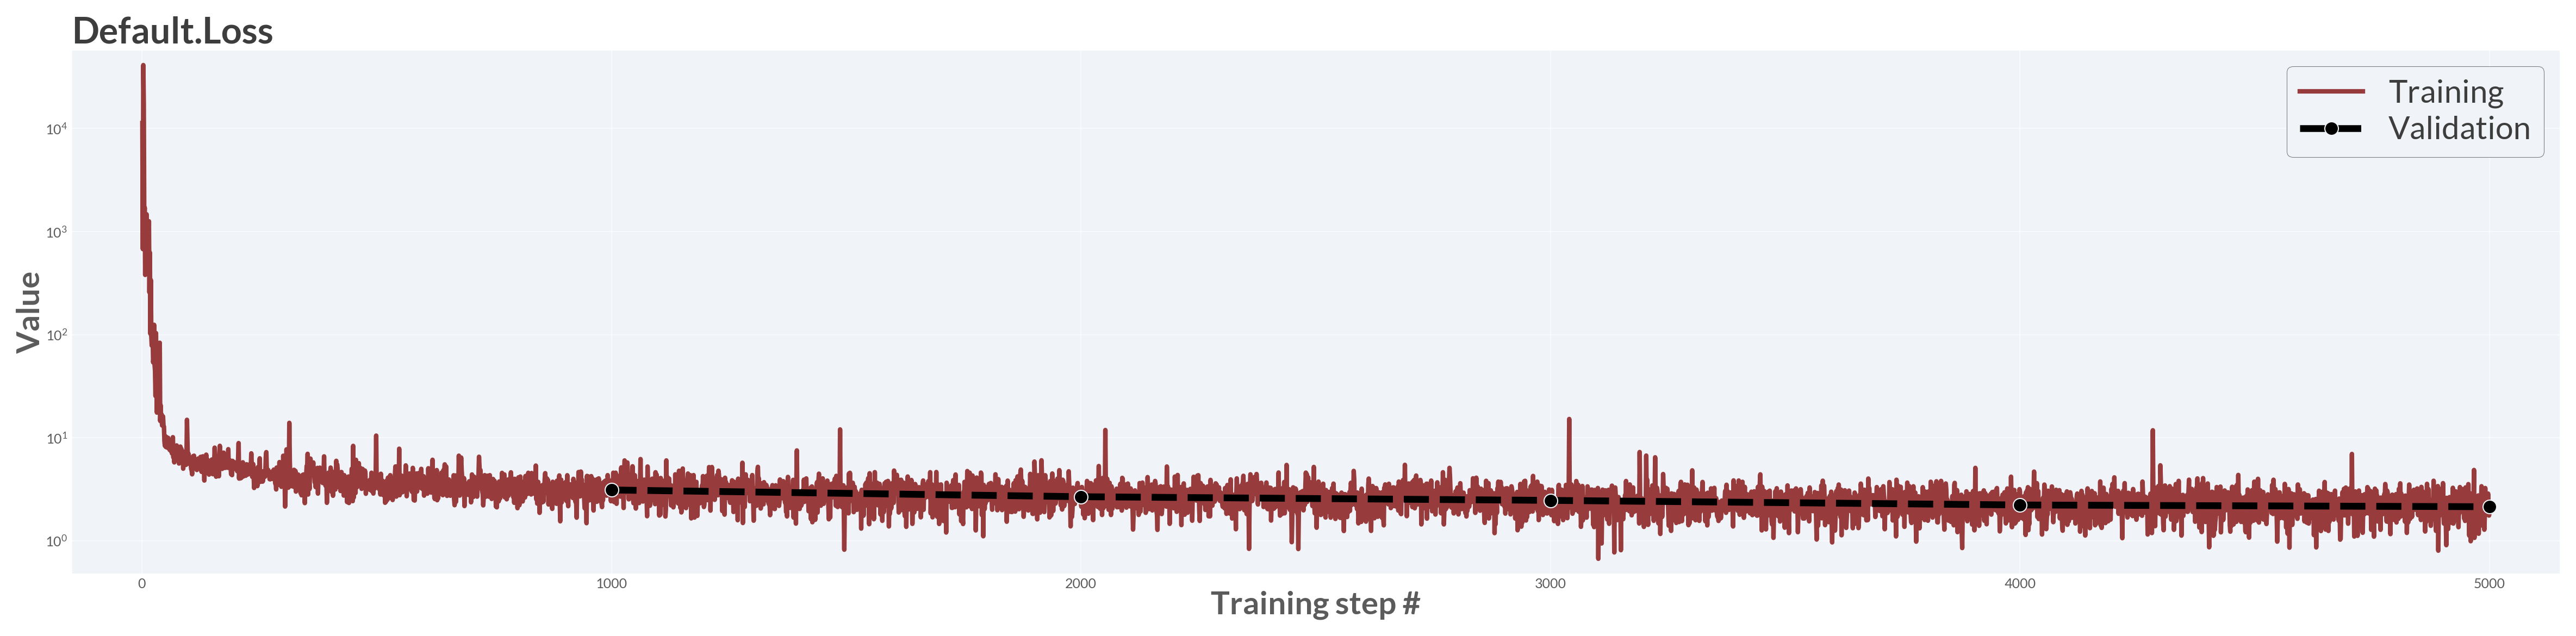

In [16]:
f = bf.diagnostics.plot_losses(history["train_losses"], history["val_losses"], moving_average=True)
ax = f.get_axes()
ax[0].set_yscale('log')